In [21]:
# Import packages
import numpy as np
import pandas as pd
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from sklearn.cluster import KMeans

# Utility Functions

## Electricity burden

In [3]:
# Define utility (u1) as a function of non-electricity spendings
def u1(alpha, c):
    return (((c - 0.85) / 0.15 + 1) ** (1 - alpha) - 1) / ( 1 - alpha)


In [4]:
# Plot u1
N = 100
c = np.linspace(0.85, 1, N)

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=c, y=u1(alpha=0, c=c),
                    mode='lines', name='a=0'))
fig.add_trace(go.Scatter(x=c, y=u1(alpha=2, c=c),
                    mode='lines', name='a=2'))
fig.add_trace(go.Scatter(x=c, y=u1(alpha=10, c=c),
                    mode='lines', name='a=10'))
fig.add_trace(go.Scatter(x=c, y=u1(alpha=-2, c=c),
                    mode='lines', name='a=-2'))
fig.update_layout(template="simple_white")
fig.update_layout(
    width = 500,
    height = 500,
    xaxis_title="Non-electricity spending share",
    yaxis_title="Utility, u1",
    yaxis_range=[0,1]
)

fig.show()
# fig.write_image("graphs/f1.png", scale=8)


## Clean energy consumption

In [5]:
# Define utility (u2) as a function of clean energy consumption
def u2(beta, c):
    return (c) ** (1 - beta)


In [6]:
# Plot u2
N = 100
c = np.linspace(0, 1, N)

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=c, y=u2(beta=0, c=c),
                    mode='lines', name='b=0'))
fig.add_trace(go.Scatter(x=c, y=u2(beta=0.2, c=c),
                    mode='lines', name='b=0.2'))
fig.add_trace(go.Scatter(x=c, y=u2(beta=0.8, c=c),
                    mode='lines', name='b=0.8'))
fig.update_layout(template="simple_white")
fig.update_layout(
    width = 500,
    height = 500,
    xaxis_title="Clean energy consumption share",
    yaxis_title="Utility, u2"
)

fig.show()
# fig.write_image("graphs/f2.png", scale=8)

# Input IEEE datasets

In [8]:
# Read IEEE datasets
demo = pd.read_excel("data_ieee/demographic.xlsx")
demand = pd.read_excel("data_ieee/electricity_demand.xlsx")
tariff = pd.read_excel("data_ieee/electricity_tariff.xlsx")
gen = pd.read_excel("data_ieee/generation_profiles.xlsx")
network = pd.read_excel("data_ieee/grid_network.xlsx")
node = pd.read_excel("data_ieee/grid_node.xlsx")
param = pd.read_excel("data_ieee/parameters.xlsx")

In [9]:
# Show 5 random rows of the demographic dataset
demo.sample(5)

,node_id,population,per_capita_annual_income
14,14,10000,75000
0,0,10000,15000
32,32,10000,200000
6,6,10000,25000
9,9,10000,35000


In [13]:
# Show the first 5 rows of the demand dataset
demand.head(5)

,node_id,month,demand_mw
0,all_nodes,"[7,8,9]",3.0
1,all_nodes,"[7,8,9]",2.0
2,all_nodes,"[7,8,9]",1.8
3,all_nodes,"[7,8,9]",1.5
4,all_nodes,"[7,8,9]",1.5


In [12]:
# Show the first 5 rows of the tariff file
tariff.head(5)

,hour_start,energy_rate_dollar_per_kwh
0,0,0.41
1,1,0.41
2,2,0.41
3,3,0.41
4,4,0.41


In [14]:
# Show the first 5 rows of the normalized generation profile
gen.head(5)

,node_id,month,hour_start,normalized_solar,normalized_wind
0,all_nodes,"[7,8,9]",0,0.0,0.550
1,all_nodes,"[7,8,9]",1,0.0,0.550
2,all_nodes,"[7,8,9]",2,0.0,0.500
3,all_nodes,"[7,8,9]",3,0.0,0.500
4,all_nodes,"[7,8,9]",4,0.0,0.475


In [15]:
# Show 5 random rows of the transmission network dataset (the so-called topology)
network.sample(5)

,edge_id,node_id_from,node_id_to,R
11,11,5,10,0.0007
12,12,6,7,0.0004
0,0,0,1,0.0035
7,7,3,13,0.0008
5,5,2,17,0.0011


In [16]:
# Show 5 random rows of the nodal dataset
node.sample(5)

,node_id,coordinate_x,coordinate_y,cap_max_mw,cap_ins_mw,Voltage (for PV),Load (MW),Generation(MW)
26,26,0.75,0.6,15,0,NaN,281.0,0
31,31,NaN,NaN,15,0,NaN,0.0,0
32,32,NaN,NaN,15,0,NaN,0.0,0
21,21,NaN,NaN,15,0,NaN,0.0,0
27,27,0.90,0.6,15,0,NaN,206.0,0


In [17]:
# Show simulation parameters
param

,category,variable,description,unit,value
0,equity,alpha,alpha,number,2.00
1,equity,beta,beta,number,0.50
2,cost,b,budget,million $,3.00
3,cost,r,discount rate,number,0.06
4,cost,f,capital recovery factor,number,0.15
5,cost,capex_solar,solar capex,$ per kWp,2743.00
6,cost,opex_solar,solar opex,$ per kWh,0.00
7,cost,capex_wind,wind capex,$ per kW,2275.00
8,cost,opex_wind,wind opex,$ per kWh,0.00
9,cost,capex_battery,battery capex,$ per kW,3746.00


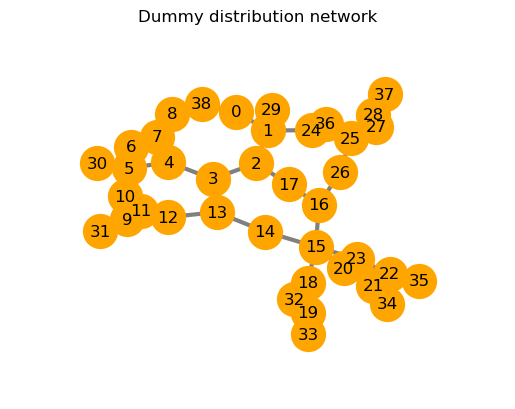

In [18]:
# Plot the distribution network
G = nx.Graph()
pos = {}

G.add_nodes_from(list(node["node_id"]))
for i in range(node.shape[0]):
    pos[node["node_id"][i]] = (node["coordinate_x"][i], node["coordinate_y"][i]) 
for i in range(network.shape[0]):
    G.add_edge(network["node_id_from"][i], network["node_id_to"][i])

options = {
    "font_size": 12,
    "node_size": 500,
    "node_color": "orange",
    "edge_color": "gray",
    "linewidths": 3,
    "width": 3,

}
nx.draw_networkx(G, **options)

ax = plt.gca()
ax.margins(0.20)
plt.title("Dummy distribution network")
plt.axis("off")
plt.show()

In [22]:
# Map edges to nodes
M = pd.DataFrame(data=0,
                 columns=network["edge_id"], 
                 index=node["node_id"])
for i in network["edge_id"]:
    node_from = network[network["edge_id"] == i].reset_index(drop=True)["node_id_from"][0]
    node_to = network[network["edge_id"] == i].reset_index(drop=True)["node_id_to"][0]
    M.loc[node_from, i] = 1
    M.loc[node_to, i] = -1

M = M.to_numpy()
M

array([[ 1,  1,  0, ...,  0,  0,  0],
       [-1,  0,  1, ...,  1,  0,  0],
       [ 0,  0, -1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0, -1,  0],
       [ 0, -1,  0, ...,  0,  0,  0]])

In [23]:
# Cluster wind/solar generation profiles using k-means
pv = pd.read_excel("data_ieee/pv_92037.xlsx")
pv["ac_normalized"] = pv["AC System Output (W)"] / 4000 
pv_reshaped = np.array(pv["ac_normalized"]).reshape(365, 24)

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(pv_reshaped)
# pd.DataFrame(np.transpose(kmeans.cluster_centers_)).to_csv("data_ieee/pv_92037_normalized.csv")


# Optimization Model

## Read parameters and input data

In [28]:
# Read simulation parameters
alpha = param[param["variable"] == "alpha"]["value"].to_list()[0]
beta = param[param["variable"] == "beta"]["value"].to_list()[0]
b = param[param["variable"] == "b"]["value"].to_list()[0]
r = param[param["variable"] == "r"]["value"].to_list()[0]
f = param[param["variable"] == "f"]["value"].to_list()[0]
capex_solar = param[param["variable"] == "capex_solar"]["value"].to_list()[0]
opex_solar = param[param["variable"] == "opex_solar"]["value"].to_list()[0]
capex_wind = param[param["variable"] == "capex_wind"]["value"].to_list()[0]
opex_wind = param[param["variable"] == "opex_wind"]["value"].to_list()[0]
capex_battery = param[param["variable"] == "capex_battery"]["value"].to_list()[0]
opex_battery = param[param["variable"] == "opex_battery"]["value"].to_list()[0]
duration_battery = param[param["variable"] == "duration_battery"]["value"].to_list()[0]

# Read IEEE input data
node_number = len(node["node_id"])
edge_number = len(network["node_id_from"])
cap_max_mw = node["cap_max_mw"]
cap_ins_mw = node["cap_ins_mw"]

# Add gaussian noises to installed VRE capacities at each node
cap_ins_mw[0:26] = cap_ins_mw[0:26] + np.random.normal(0.5, 0.25, 26).clip(min=0)
cap_ins_mw[26:] = cap_ins_mw[26:] + np.random.normal(2, 1, 13).clip(min=0)


## Process demographics data

In [30]:
# Calculate old electricity burden
old_bill_list = []
old_spending_power_list = []
old_utility_list = []
for i in range(len(node["node_id"])):
    
    node_id = node["node_id"][i]
    population = demo[demo["node_id"] == node_id].reset_index(drop=True)["population"][0]
    annual_income = demo[demo["node_id"] == node_id].reset_index(drop=True)["per_capita_annual_income"][0]
    demand_profile = demand["demand_mw"] # MW
    demand_days = int(len(demand["demand_mw"]) / 24)
    mapped_tariff = tariff["energy_rate_dollar_per_kwh"].tolist() * demand_days
    
    # Calculate old electricity bills
    per_capita_old_annual_bill = np.dot(demand_profile * 1e3, 
                                        mapped_tariff) / population / demand_days * 365
    old_bill_list.append(per_capita_old_annual_bill)
    
    # calculate old electricity burden 
    old_spending_power = (annual_income - per_capita_old_annual_bill) / annual_income
    old_spending_power_list.append(old_spending_power)
    
    # Calculate old electricity utility (u1)
    old_utility = u1(alpha=alpha, c=old_spending_power)
    old_utility_list.append(old_utility)

# Update the demographic dataset
demo["per_capita_annual_bill"] = old_bill_list
demo["spending_power"] = old_spending_power_list
demo["per_capita_utility"] = old_utility_list
demo["per_node_utility"] = old_utility_list * demo["population"]
demo["per_capita_pollution_cost"] = np.random.uniform(0.03, 0.35, len(demo["node_id"]))
demo


,node_id,population,per_capita_annual_income,per_capita_annual_bill,spending_power,per_capita_utility,per_node_utility,per_capita_pollution_cost
0,0,10000,15000,1889.80575,0.874013,0.137995,1379.951894,0.265514
1,1,10000,15000,1889.80575,0.874013,0.137995,1379.951894,0.169749
2,2,10000,15000,1889.80575,0.874013,0.137995,1379.951894,0.095068
3,3,10000,15000,1889.80575,0.874013,0.137995,1379.951894,0.161495
4,4,10000,25000,1889.80575,0.924408,0.331574,3315.739468,0.053255
5,5,10000,25000,1889.80575,0.924408,0.331574,3315.739468,0.117749
6,6,10000,25000,1889.80575,0.924408,0.331574,3315.739468,0.184471
7,7,10000,35000,1889.80575,0.946006,0.390258,3902.576588,0.080892
8,8,10000,35000,1889.80575,0.946006,0.390258,3902.576588,0.059168
9,9,10000,35000,1889.80575,0.946006,0.390258,3902.576588,0.337752


## Build a toy model (no power flows)

In [177]:
# No power flows

# read parameters
alpha = param[param["variable"] == "alpha"]["value"].to_list()[0]
beta = param[param["variable"] == "beta"]["value"].to_list()[0]
# b = param[param["variable"] == "b"]["value"].to_list()[0]
b = 100
r = param[param["variable"] == "r"]["value"].to_list()[0]
f = param[param["variable"] == "f"]["value"].to_list()[0]
capex_solar = param[param["variable"] == "capex_solar"]["value"].to_list()[0]
opex_solar = param[param["variable"] == "opex_solar"]["value"].to_list()[0]
capex_wind = param[param["variable"] == "capex_wind"]["value"].to_list()[0]
opex_wind = param[param["variable"] == "opex_wind"]["value"].to_list()[0]
capex_battery = param[param["variable"] == "capex_battery"]["value"].to_list()[0]
opex_battery = param[param["variable"] == "opex_battery"]["value"].to_list()[0]
duration_battery = param[param["variable"] == "duration_battery"]["value"].to_list()[0]

# read other input data
node_number = len(node["node_id"])
edge_number = len(network["node_id_from"])
cap_max_mw = node["cap_max_mw"]
cap_ins_mw = node["cap_ins_mw"]

# define variables
s = cp.Variable(node_number) # in [MW]
w = cp.Variable(node_number) # in [MW]

# define constraints
constraints = []
# nonnegative variables
constraints.append(s >= 0)
constraints.append(w >= 0)
# budget constraint, in [$]
constraints.append(cp.sum(s * capex_solar * 1e3 + w * capex_wind * 1e3) <= b * 1e6)
# DER deployment constriant
constraints.append((s + w) <= cap_max_mw - cap_ins_mw)
# calculate net demand and new electricity bill
new_utility_list = []
for i in range(len(node["node_id"])):
    # obtain data per node
    node_id = node["node_id"][i]
    population = demo[demo["node_id"] == node_id].reset_index(drop=True)["population"][0]
    annual_income = demo[demo["node_id"] == node_id].reset_index(drop=True)["per_capita_annual_income"][0]
    demand_profile = demand["demand_mw"] # MW
    demand_days = int(len(demand["demand_mw"]) / 24)
    mapped_tariff = tariff["energy_rate_dollar_per_kwh"].tolist() * demand_days
    net_demand_profile = np.array(demand_profile) - \
        s[i] * gen["normalized_solar"] - \
        w[i] * gen["normalized_wind"] # MW
    
    # calculate new non-electricity spending power and utility per capita
    per_capita_new_annual_bill = net_demand_profile.T @ mapped_tariff * 1e3 / population / demand_days * 365
    new_spending_power = (annual_income - per_capita_new_annual_bill) / annual_income
    new_utility = u1(alpha=alpha, c=new_spending_power)
    new_utility_list.append(new_utility)
    
    # assume that no net metering is allowed (i.e., net demand >= 0)
    constraints.append(net_demand_profile >= 0)

# define objective function (maximizing concave functions => DCP compliant)
total_utility = cp.Maximize(cp.sum(np.array(new_utility_list).T @ demo["population"]))

# solve the problem 
prob = cp.Problem(total_utility, 
                  constraints)
prob.solve(verbose=False, solver=cp.CVXOPT)

# print result
print("\nThe optimal total utility is", prob.value)
print("The optimal solar capacity is")
print(s.value.round(2))
print("The optimal wind capacity is")
print(w.value.round(2))



The optimal total utility is 169551.82534620253
The optimal solar capacity is
[ 6.63  6.63  6.63  6.63  0.    0.    0.   -0.   -0.   -0.   -0.   -0.
 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
 -0.   -0.   -0.  ]
The optimal wind capacity is
[ 3.  3.  3.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.]


## Build a FULL toy model (with power flows)

In [31]:
# Include power flows

def run_opt(alpha, beta, b, scenario=1, verbose=False):
    # Define decision variables
    s = cp.Variable(node_number) # in [MW], N x 1
    w = cp.Variable(node_number) # in [MW], N x 1
    q = cp.Variable((edge_number, 4 * 24)) # in [MW], E x days
    g = cp.Variable((node_number, 4 * 24)) # in [MW], N x days

    # Define constraints
    constraints = []
    # nonnegative variables
    constraints.append(s >= 0)
    constraints.append(w >= 0)
    # budget constraint, in [$]
    constraints.append(cp.sum(s * capex_solar * 1e3 + w * capex_wind * 1e3) <= b * 1e6)
    # DER deployment constriant
    constraints.append((s + w) <= cap_max_mw - cap_ins_mw)
    
    # Calculate net demand and new electricity bill
    new_utility_list = []
    for i in range(len(node["node_id"])):
        
        # Obtain attributes per node
        node_id = node["node_id"][i]
        population = demo[demo["node_id"] == node_id].reset_index(drop=True)["population"][0]
        annual_income = demo[demo["node_id"] == node_id].reset_index(drop=True)["per_capita_annual_income"][0]
        demand_profile = demand["demand_mw"] # MW
        demand_days = int(len(demand["demand_mw"]) / 24)
        mapped_tariff = tariff["energy_rate_dollar_per_kwh"].tolist() * demand_days
        
        # Obtain net demand = demand - VRE generation
        net_demand_profile = np.array(demand_profile) - \
            s[i] * gen["normalized_solar"] - \
            w[i] * gen["normalized_wind"] # MW

        # assume that no net metering is allowed (i.e., net demand >= 0)
        constraints.append(net_demand_profile >= 0)

        # demand-supply constraints (q_in - q_out + utility_gen = net_demand)
        power_flow = M @ q + g
        constraints.append(power_flow[i].T == net_demand_profile)
        
        # assume that every node has sufficient generating resources
        constraints.append(g <= 20)
        
        # assume that only node 0 and 3 has 20 GW of generating resources each
#         if i not in [0, 3]:
#             constraints.append(g[i] == 0)

        # Add additional scenarios depending on the scenario:
        if scenario == 2:
            # LMI nodes have lower transformer capacities
            constraints.append((s[0:13] + w[0:13]) <= cap_max_mw[0:13] * 0.5 - cap_ins_mw[0:13])
        elif scenario == 3:
            # Each node have at least 2% of program investments
            constraints.append((s[i] + w[i]) >= 0.02 * (cp.sum(s) + cp.sum(w)))
        elif scenario == 4:
            # Internalize the healthcare costs
            health_cost = demo[demo["node_id"] == node_id].reset_index(drop=True)["per_capita_pollution_cost"][0]
            mapped_tariff = mapped_tariff - health_cost
        else:
            pass
        
        # Calculate new non-electricity spending power and clean energy share
        per_capita_new_annual_bill = net_demand_profile.T @ mapped_tariff * 1e3 / population / demand_days * 365
        new_spending_power = (annual_income - per_capita_new_annual_bill) / annual_income
        clean_energy_share = (cp.sum(s[i] * gen["normalized_solar"]) + 
                              cp.sum(w[i] * gen["normalized_wind"])) / sum(demand_profile)
        
        # Calculate the new utilities (u1, u2) with VRE adoption
        new_utility = u1(alpha=alpha, c=new_spending_power) + \
                      u2(beta=beta, c=clean_energy_share)
        new_utility_list.append(new_utility)

    # Add power flow constraints
    # # power transfers < line capacity at all hours
    # for i in network["edge_id"]:
    #     constraints.append(q[i] <= 5.5)    
    #     constraints.append(q[i] >= -5)

    # Define the objective function (maximizing concave functions => DCP compliant)
    total_utility = cp.Maximize(
        cp.sum(
            np.array(new_utility_list).T @ demo["population"]))

    # Solve the problem 
    prob = cp.Problem(total_utility, 
                      constraints)
    prob.solve(verbose=False, solver=cp.ECOS)

    # Print/save the results
    results = {}
    results["total_utility"] = prob.value.round(2)
    results["new_solar_cap"] = s.value.round(2)
    results["new_wind_cap"] = w.value.round(2)
    
    if verbose:    
        print("\nThe optimal total utility is", prob.value)
        print("The optimal solar capacity is")
        print(s.value.round(2))
        print("The optimal wind capacity is")
        print(w.value.round(2))
        print("The generated electricity is")
        print(pd.DataFrame(g.value.round(2)))
        print("Power flows are")
        print(pd.DataFrame(q.value.round(2)))
    else:
        pass
    
    return results


# Preliminary Results 

## Scenario 1: Given alpha & beta as budget increases

In [32]:
# Initialize the result dataframe
df = pd.DataFrame(columns=["b", "new_solar_cap", "new_wind_cap"])
# Initialize the budget list
budget_list = [50, 100, 150, 200, 300, 400, 600, 800, 1000] 

# For a given budget, run the optimization model and store the results
for b_i in budget_list:
    results = run_opt(alpha=2, beta=0, b=b_i, scenario=1, verbose=False)
    d = pd.DataFrame()
    d["b"] = [b_i] * node_number
    d["node_id"] = np.array([str(i) for i in range(node_number)])
    d["new_solar_cap"] = results["new_solar_cap"]
    d["new_wind_cap"] = results["new_wind_cap"]
    df = pd.concat([df, d], ignore_index=True)
    # print(f"budget @ {b_i}", results)
df = df.reset_index(drop=True)
df.head(5)

,b,new_solar_cap,new_wind_cap,node_id
0,50,0.0,3.0,0
1,50,0.0,3.0,1
2,50,0.0,3.0,2
3,50,0.0,3.0,3
4,50,0.0,3.0,4


In [30]:
# Save the results to csv 
df.to_csv("graphs/d_r1.csv")

In [35]:
# Plot the full results
fig = make_subplots(rows=9, cols=1, shared_xaxes=True, 
                    y_title='Installed capacity (MW)',
                    x_title='Node ID',
                    subplot_titles=("50", "100", "150", "200", "300", "400", "600", "800", "1000"),
                    vertical_spacing=0.05
                   )

for i in [i for i in range(len(budget_list))]:
    d = df[df["b"] == budget_list[i]].reset_index(drop=True)
    legend_show = True if i == 0 else False
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_solar_cap"], 
                         name="Solar", showlegend=legend_show,
                         marker_color="#C69214"), row=i+1, col=1)
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_wind_cap"], 
                         name="Wind", showlegend=legend_show,
                         marker_color="#00629B"), row=i+1, col=1)
    fig.update_yaxes(range=[0, 10], row=i+1, col=1)

fig.update_layout(
    font=dict(size=16),
    template="simple_white", barmode="stack",
    width = 1800, height = 1200,
#     title="DER capacity as budget increases",
)

fig.show()
# fig.write_image("graphs/f_r1.png", scale=8)

In [36]:
# Plot a subset of the results
budget_list = [200, 400, 600, 800]
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                    y_title='Installed capacity (MW)',
                    x_title='Node ID',
                    subplot_titles=("Low budget (200m)", "400", "600", "High budget (800m)"),
                    vertical_spacing=0.1
                   )

for i in [i for i in range(len(budget_list))]:
    d = df[df["b"] == budget_list[i]].reset_index(drop=True)
    legend_show = True if i == 0 else False
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_solar_cap"], 
                         name="Solar", showlegend=legend_show,
                         marker_color="#C69214"), row=i+1, col=1)
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_wind_cap"], 
                         name="Wind", showlegend=legend_show,
                         marker_color="#00629B"), row=i+1, col=1)
    fig.update_yaxes(range=[0, 10], row=i+1, col=1)

fig.update_layout(
    font=dict(size=16),
    template="simple_white", barmode="stack",
    width = 1200, height = 600,
#     title="DER capacity as budget increases",
)

fig.show()
# fig.write_image("graphs/f_r1_simplified.png", scale=8)

## Scenario 2: LMI nodes have lower hosting capacities

In [39]:
# Initialize the result dataframe
df = pd.DataFrame(columns=["b", "new_solar_cap", "new_wind_cap"])
# Initialize the budget list
budget_list = [50, 100, 150, 200, 300, 400, 600, 800, 1000]

# For a given budget, run the optimization model
for b_i in budget_list:
    results = run_opt(alpha=2, beta=0, b=b_i, scenario=2, verbose=False)
    d = pd.DataFrame()
    d["b"] = [b_i] * node_number
    d["node_id"] = np.array([str(i) for i in range(node_number)])
    d["new_solar_cap"] = results["new_solar_cap"]
    d["new_wind_cap"] = results["new_wind_cap"]
    df = pd.concat([df, d], ignore_index=True)
    # print(f"budget @ {b_i}", results)
df = df.reset_index(drop=True)

# Plot the full results
fig = make_subplots(rows=9, cols=1, shared_xaxes=True, 
                    y_title='Installed capacity (MW)',
                    x_title='Node ID',
                    subplot_titles=("50", "100", "150", "200", "300", "400", "600", "800", "1000"),
                    vertical_spacing=0.05
                   )

for i in [i for i in range(len(budget_list))]:
    d = df[df["b"] == budget_list[i]].reset_index(drop=True)
    legend_show = True if i == 0 else False
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_solar_cap"], 
                         name="Solar", showlegend=legend_show,
                         marker_color="#C69214"), row=i+1, col=1)
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_wind_cap"], 
                         name="Wind", showlegend=legend_show,
                         marker_color="#00629B"), row=i+1, col=1)
    fig.update_yaxes(range=[0, 10], row=i+1, col=1)

fig.update_layout(
    font=dict(size=16),
    template="simple_white", barmode="stack",
    width = 1800, height = 1200,
#     title="DER capacity as budget increases",
)

fig.show()
# fig.write_image("graphs/f_r2.png", scale=8)

In [32]:
# Save the results to csv 
df.to_csv("graphs/d_r2.csv")

In [40]:
# Plot a subset of the results
budget_list = [200, 400, 600, 800]
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                    y_title='Installed capacity (MW)',
                    x_title='Node ID',
                    subplot_titles=("Low budget (200m)", "400", "600", "High budget (800m)"),
                    vertical_spacing=0.1
                   )

for i in [i for i in range(len(budget_list))]:
    d = df[df["b"] == budget_list[i]].reset_index(drop=True)
    legend_show = True if i == 0 else False
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_solar_cap"], 
                         name="Solar", showlegend=legend_show,
                         marker_color="#C69214"), row=i+1, col=1)
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_wind_cap"], 
                         name="Wind", showlegend=legend_show,
                         marker_color="#00629B"), row=i+1, col=1)
    fig.update_yaxes(range=[0, 10], row=i+1, col=1)

fig.update_layout(
    font=dict(size=16),
    template="simple_white", barmode="stack",
    width = 1200, height = 600,
#     title="DER capacity as budget increases",
)

fig.show()
# fig.write_image("graphs/f_r2_simplified.png", scale=8)

## Scenario 3: Each node has at least 2% of program investments

In [43]:
# Initialize the result dataframe
df = pd.DataFrame(columns=["b", "new_solar_cap", "new_wind_cap"])
# Initialize the budget list
budget_list = [50, 100, 150, 200, 300, 400, 600, 800, 1000] 

# For a given budget, run the optimization model
for b_i in budget_list:
    results = run_opt(alpha=2, beta=0, b=b_i, scenario=3, verbose=False)
    d = pd.DataFrame()
    d["b"] = [b_i] * node_number
    d["node_id"] = np.array([str(i) for i in range(node_number)])
    d["new_solar_cap"] = results["new_solar_cap"]
    d["new_wind_cap"] = results["new_wind_cap"]
    df = pd.concat([df, d], ignore_index=True)
    # print(f"budget @ {b_i}", results)
df = df.reset_index(drop=True)

# Plot the full results
fig = make_subplots(rows=9, cols=1, shared_xaxes=True, 
                    y_title='Installed capacity (MW)',
                    x_title='Node ID',
                    subplot_titles=("50", "100", "150", "200", "300", "400", "600", "800", "1000"),
                    vertical_spacing=0.05
                   )

for i in [i for i in range(len(budget_list))]:
    d = df[df["b"] == budget_list[i]].reset_index(drop=True)
    legend_show = True if i == 0 else False
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_solar_cap"], 
                         name="Solar", showlegend=legend_show,
                         marker_color="#C69214"), row=i+1, col=1)
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_wind_cap"], 
                         name="Wind", showlegend=legend_show,
                         marker_color="#00629B"), row=i+1, col=1)
    fig.update_yaxes(range=[0, 10], row=i+1, col=1)

fig.update_layout(
    font=dict(size=16),
    template="simple_white", barmode="stack",
    width = 1800, height = 1200,
#     title="DER capacity as budget increases",
)

fig.show()
# fig.write_image("graphs/f_r3.png", scale=8)

In [34]:
# Save the results
df.to_csv("graphs/d_r3.csv")

In [44]:
# Plot a subset of the results
budget_list = [200, 400, 600, 800]
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                    y_title='Installed capacity (MW)',
                    x_title='Node ID',
                    subplot_titles=("Low budget (200m)", "400", "600", "High budget (800m)"),
                    vertical_spacing=0.1
                   )

for i in [i for i in range(len(budget_list))]:
    d = df[df["b"] == budget_list[i]].reset_index(drop=True)
    legend_show = True if i == 0 else False
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_solar_cap"], 
                         name="Solar", showlegend=legend_show,
                         marker_color="#C69214"), row=i+1, col=1)
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_wind_cap"], 
                         name="Wind", showlegend=legend_show,
                         marker_color="#00629B"), row=i+1, col=1)
    fig.update_yaxes(range=[0, 10], row=i+1, col=1)

fig.update_layout(
    font=dict(size=16),
    template="simple_white", barmode="stack",
    width = 1200, height = 600,
#     title="DER capacity as budget increases",
)

fig.show()
# fig.write_image("graphs/f_r3_simplified.png", scale=8)

## Scenario 4: Internalize the avoided costs of pollution

In [45]:
# Initialize the result dataframe
df = pd.DataFrame(columns=["b", "new_solar_cap", "new_wind_cap"])
# Initialize the budget list
budget_list = [50, 100, 150, 200, 300, 400, 600, 800, 1000] 

# For a given budget, run the optimization model
for b_i in budget_list:
    results = run_opt(alpha=2, beta=0, b=b_i, scenario=4, verbose=False)
    d = pd.DataFrame()
    d["b"] = [b_i] * node_number
    d["node_id"] = np.array([str(i) for i in range(node_number)])
    d["new_solar_cap"] = results["new_solar_cap"]
    d["new_wind_cap"] = results["new_wind_cap"]
    df = pd.concat([df, d], ignore_index=True)
    # print(f"budget @ {b_i}", results)
df = df.reset_index(drop=True)

# Plot the full results
fig = make_subplots(rows=9, cols=1, shared_xaxes=True, 
                    y_title='Installed capacity (MW)',
                    x_title='Node ID',
                    subplot_titles=("50", "100", "150", "200", "300", "400", "600", "800", "1000"),
                    vertical_spacing=0.05
                   )

for i in [i for i in range(len(budget_list))]:
    d = df[df["b"] == budget_list[i]].reset_index(drop=True)
    legend_show = True if i == 0 else False
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_solar_cap"], 
                         name="Solar", showlegend=legend_show,
                         marker_color="#C69214"), row=i+1, col=1)
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_wind_cap"], 
                         name="Wind", showlegend=legend_show,
                         marker_color="#00629B"), row=i+1, col=1)
    fig.update_yaxes(range=[0, 10], row=i+1, col=1)

fig.update_layout(
    font=dict(size=16),
    template="simple_white", barmode="stack",
    width = 1800, height = 1200,
#     title="DER capacity as budget increases",
)

fig.show()
# fig.write_image("graphs/f_r4.png", scale=8)

In [46]:
# Plot a subset of the results
budget_list = [200, 400, 600, 800]
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                    y_title='Installed capacity (MW)',
                    x_title='Node ID',
                    subplot_titles=("Low budget (200m)", "400", "600", "High budget (800m)"),
                    vertical_spacing=0.1
                   )

for i in [i for i in range(len(budget_list))]:
    d = df[df["b"] == budget_list[i]].reset_index(drop=True)
    legend_show = True if i == 0 else False
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_solar_cap"], 
                         name="Solar", showlegend=legend_show,
                         marker_color="#C69214"), row=i+1, col=1)
    fig.add_trace(go.Bar(x=d["node_id"], y=d["new_wind_cap"], 
                         name="Wind", showlegend=legend_show,
                         marker_color="#00629B"), row=i+1, col=1)
    fig.update_yaxes(range=[0, 10], row=i+1, col=1)

fig.update_layout(
    font=dict(size=16),
    template="simple_white", barmode="stack",
    width = 1200, height = 600,
#     title="DER capacity as budget increases",
)

fig.show()
# fig.write_image("graphs/f_r4_simplified.png", scale=8)

In [28]:
# Save the results
df.to_csv("graphs/d_r4.csv")